In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import random
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import loglaplace, lognorm, laplace, norm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.special import erf
warnings.filterwarnings('ignore')
sns.set(style="white", context="talk")
np.random.seed(42)

## S3.1 Numerical Computation of $\Omega$

In [2]:
θ = 2    # true state of the world
μ = np.linspace(-3,3,31)
σ = np.logspace(-1,1,21)
n_samples = 5000
ω=1/3
n = 50

### Function Definitions

In [3]:
def signal_lognormal(n, m=1e-3, a = 1.0):
    # sample bias for each agent from a lognormal distribution
    # μ_normal is the mean of the underlying normal distribution. 
    # This function returns lognormal distributions that have a median m 
    # and variance a
    
    s = np.random.lognormal(mean= np.log(θ) + m ,sigma = a,size=n)
    return s

def signal_normal(n,θ, m=1e-3, a = 1.0):
    # sample bias for each agent from a lognormal distribution
    # μ_normal is the mean of the underlying normal distribution. 
    # This function returns lognormal distributions that have a median m 
    # and variance a
    
    s = np.abs(np.random.normal(loc=θ*np.exp(m) ,scale = a,size=n))
    return s

def signal_pareto(n, m=1e-3, a = 1.0):
    # sample bias for each agent from a lognormal distribution
    # μ_normal is the mean of the underlying normal distribution. 
    # This function returns lognormal distributions that have a median m 
    # and variance a
    
    s = (np.random.pareto(1/a, n) + 1) * (θ*np.exp(m))
    return s

def signal_loglaplace(n, θ = 1.0, μ = 1.0, σ = 1):
    # sample bias for each agent from a lognormal distribution
    # μ_normal is the mean of the underlying normal distribution. 
    # This function returns lognormal distributions that have a median m 
    # and variance a
    
    s = np.exp(laplace.rvs(loc=np.log(θ) + μ,scale=σ,size=n))
    return s

# small w as defined in the paper for degroot
def w_star(n):
    w = 2*np.ones(n)/(3*n - 2)
    w[0] = n/(3*n - 2)
    return w

#general ω > 0
def w_center(n):
    w = (1-ω)*np.ones(n)/n
    w[0]+=ω
    return w

def w_cycle(n):
    w = np.ones(n)/n
    return w

def plot_phase(mu,sigma,Omega,lines=True, save=False, title=None):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.set_yscale('log',basey=10)

    ## The body of the plot
    main_cs = ax.contourf(mu,sigma,Omega,levels=np.linspace(0,1,50),cmap='RdYlBu')

    #the color bar
    cbar = fig.colorbar(main_cs, ticks=np.linspace(0,1,5))

    #add lines in the main body of the plot (the levels)
    if lines:
        lines_cs = ax.contour(mu,sigma,Omega,levels=[0, 0.25, 0.5, 0.75,1],colors=['k'])
        #lables on the plot itself
        ax.clabel(lines_cs,lines_cs.levels,inline=True,fmt="%1.2f",fontsize=35)
        #label the color bar
        cbar.add_lines(lines_cs)
        
    cbar.ax.set_title("Ω",fontsize=40)

    ##Label the body of the plot
    ax.set_xlabel("Systematic bias, μ",fontsize=30)
    ax.set_ylabel('Dispersion, σ',fontsize=30)

    #ax.set_xlim(-2.99,2.99)
    ax.set_ylim(0.1,10)
    ax.tick_params(labelsize=30)

    ax.set_yticks((0.1,1,10))
    ax.set_yticklabels((0.1,1,10))

    if save:
        plt.savefig('./SI_phase_diagram_'+str(title)+'.pdf', bbox_inches='tight')
        
def plot_loss(mu,sigma,Omega, save=False, title=""):
    
    levels = [0,0.25,0.5,0.75,1,1.25,1.5,1.75,2]
    colors = ["#D2F4FD","#86E3FC", "#6EACE6", "#7A9CFE", 
              "#FDF1D2", "#FCDD86", "#C9B06B", "#7D7768"
             ]

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.set_yscale('log',basey=10)

    ## The body of the plot
    main_cs = ax.contourf(μμ,σσ,data,levels=levels,colors=colors)

    #the color bar
    cbar = fig.colorbar(main_cs)


    ##Label the body of the plot
    ax.set_xlabel("Systematic bias, μ",fontsize=40)
    ax.set_ylabel('Dispersion, σ',fontsize=40)
    ax.set_title(title,fontsize=40)

    #ax.set_xlim(-2.99,2.99)
    ax.set_ylim(0.1,10)
    ax.tick_params(labelsize=35)

    ax.set_yticks((0.1,1,10))
    ax.set_yticklabels((0.1,1,10))

    if save:
        plt.savefig('./SI_loss_diagram_'+str(title.replace('/', '').replace('$',''))+'.pdf', bbox_inches='tight')

### $\Omega$ simulation for gaussian

In [4]:
##This is low resolution version of the main text Figure 2

Ω = np.zeros([len(μ),len(σ)])

w_center_ = w_center(n)
w_cycle_ = w_cycle(n)

for idx_n,μn in enumerate(μ):
    for idx_α,_α in enumerate(σ):
        for i in range(n_samples):
            s = signal_normal(n,θ,m=μn,a=_α)

            center_MSE =  ((w_center_@s) - θ)**2
            cycle_MSE = ((w_cycle_@s) - θ)**2
            
            if center_MSE < cycle_MSE:
                Ω[idx_n,idx_α] += 1/n_samples
                


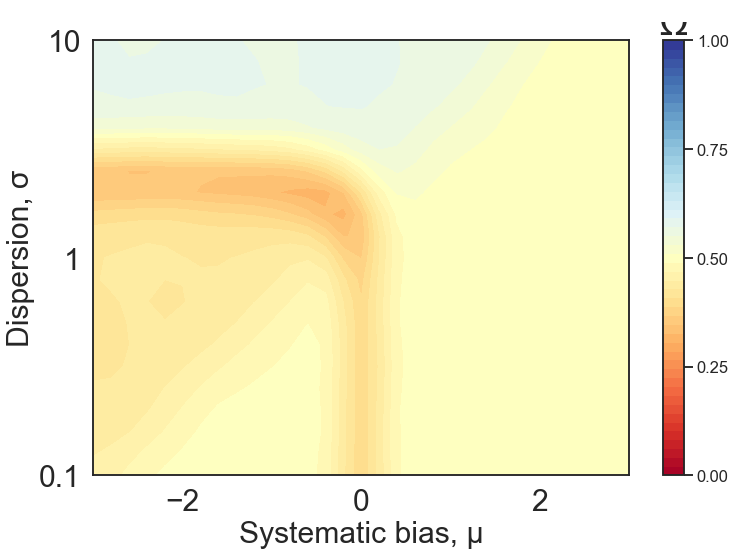

In [5]:
# This is an illustrative coarsed figure. The high resolution one is in "Fig2.Linking task features and network structure.ipynb"
μμ, σσ = np.meshgrid(μ, σ)
sigma = 1
data = gaussian_filter(Ω.T, sigma)
plot_phase(μμ,σσ,data,lines=False,save=True,title="folded_gaussian")


### $\Omega$ simulation for log normal

In [6]:
##This is low resolution version of the main text Figure 2
Ω = np.zeros([len(μ),len(σ)])

w_center_ = w_center(n)
w_cycle_ = w_cycle(n)

for idx_n,μn in enumerate(μ):
    for idx_α,_α in enumerate(σ):
        for i in range(n_samples):
            s = signal_lognormal(n,m=μn,a=_α)

            center_MSE =  ((w_center_@s) - θ)**2
            cycle_MSE = ((w_cycle_@s) - θ)**2
            
            if center_MSE < cycle_MSE:
                Ω[idx_n,idx_α] += 1/n_samples



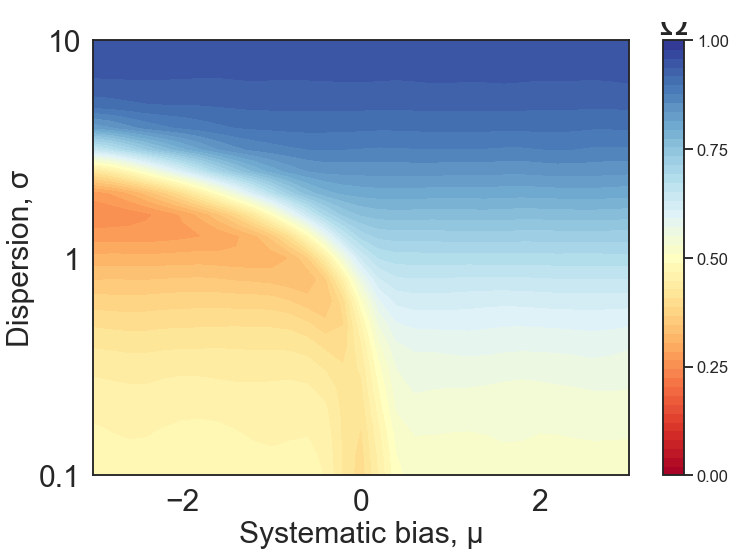

In [7]:
# This is an illustrative coarsed figure. The high resolution one is in "Fig2.Linking task features and network structure.ipynb"
μμ, σσ = np.meshgrid(μ, σ)
sigma = 1
data = gaussian_filter(Ω.T, sigma)
plot_phase(μμ,σσ,data,lines=False,save=True,title="log-normal")


### $\Omega$ simulation for loglaplace

In [8]:
##This is low resolution version of the main text Figure 2

Ω = np.zeros([len(μ),len(σ)])

w_center_ = w_center(n)
w_cycle_ = w_cycle(n)

for idx_n,μn in enumerate(μ):
    for idx_α,_α in enumerate(σ):
        for i in range(n_samples):
            s = signal_loglaplace(n,θ = θ,μ=μn,σ=_α)

            center_MSE =  ((w_center_@s) - θ)**2
            cycle_MSE = ((w_cycle_@s) - θ)**2
            
            if center_MSE < cycle_MSE:
                Ω[idx_n,idx_α] += 1/n_samples


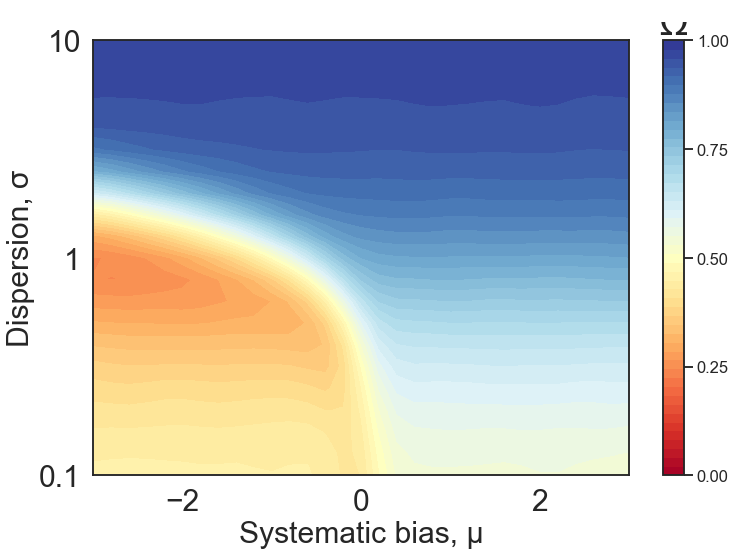

In [9]:
# This is an illustrative coarsed figure. The high resolution one is in "Fig2.Linking task features and network structure.ipynb"
μμ, σσ = np.meshgrid(μ, σ)
sigma = 1 # as we have less samples, we use less smothiening than in Fig2
data = gaussian_filter(Ω.T, sigma)
plot_phase(μμ,σσ,data,lines=False,save=True,title="log-laplace")


### $\Omega$ simulation for power law

In [10]:
##This is low resolution version of the main text Figure 2

Ω = np.zeros([len(μ),len(σ)])

w_center_ = w_center(n)
w_cycle_ = w_cycle(n)

for idx_n,μn in enumerate(μ):
    for idx_α,_α in enumerate(σ):
        for i in range(n_samples):
            s = signal_pareto(n,m=μn,a=_α)

            center_MSE =  ((w_center_@s) - θ)**2
            cycle_MSE = ((w_cycle_@s) - θ)**2
            
            if center_MSE < cycle_MSE:
                Ω[idx_n,idx_α] += 1/n_samples


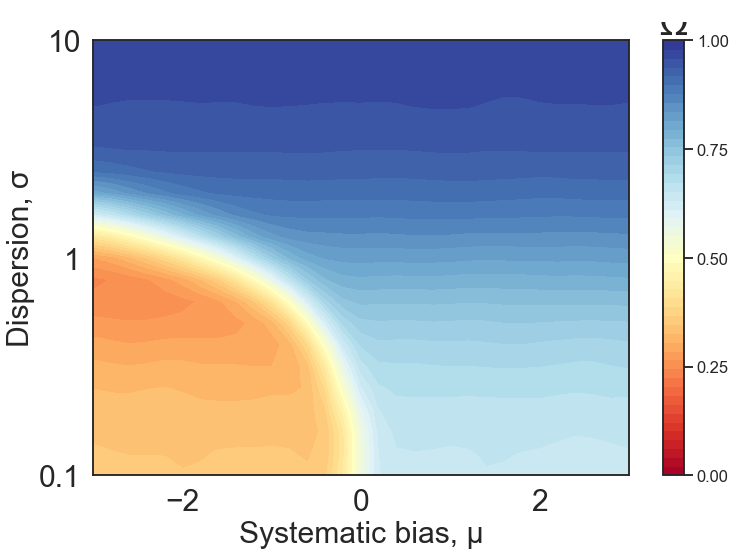

In [11]:
# This is an illustrative coarsed figure. The high resolution one is in "Fig2.Linking task features and network structure.ipynb"
μμ, σσ = np.meshgrid(μ, σ)
sigma = 1 # as we have less samples, we use less smothiening than in Fig2
data = gaussian_filter(Ω.T, sigma)
plot_phase(μμ,σσ,data,lines=False,save=True,title="pareto")


### Loss Functions

In [12]:
np.random.seed(42)

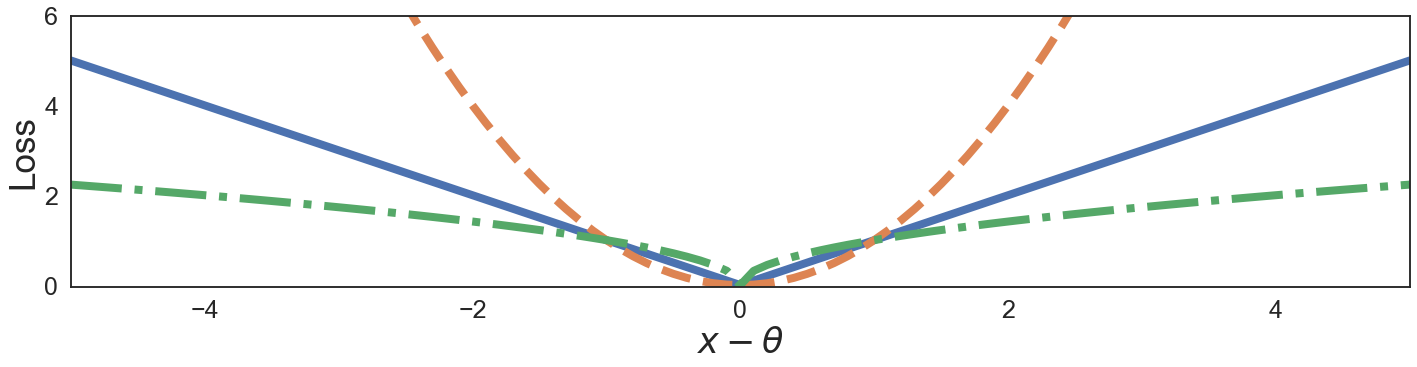

In [13]:
error = np.linspace(-5,5,101)

fig = plt.figure(figsize=(8*3,5))
ax = fig.add_subplot(111)

ax.plot(error, np.abs(error), linestyle='-', linewidth=8, label='MAE')
ax.plot(error, np.abs(error)**2, linestyle='--', linewidth=8,label='MSE')
ax.plot(error, np.sqrt(np.abs(error)), linestyle='-.',linewidth=8,label='MSRE')
ax.set_ylim(-0.05,6)
ax.set_xlim(-5,5)
ax.set_xlabel(r"$x-\theta$",fontsize=35)
ax.set_ylabel("Loss",fontsize=35)

ax.tick_params(labelsize=25)

### Mean Square Error

In [14]:
MSE_center = np.zeros([len(μ),len(σ)])
MSE_cycle = np.zeros([len(μ),len(σ)])


w_center_ = w_center(n)
w_cycle_ = w_cycle(n)

for idx_n,μn in enumerate(μ):
    for idx_α,_α in enumerate(σ):
        for i in range(n_samples):
            s = signal_lognormal(n,m=μn,a=_α)

            center_MSE =  ((w_center_@s) - θ)**2
            cycle_MSE = ((w_cycle_@s) - θ)**2
            
            MSE_center[idx_n,idx_α] += center_MSE/n_samples
            MSE_cycle[idx_n,idx_α] += cycle_MSE/n_samples

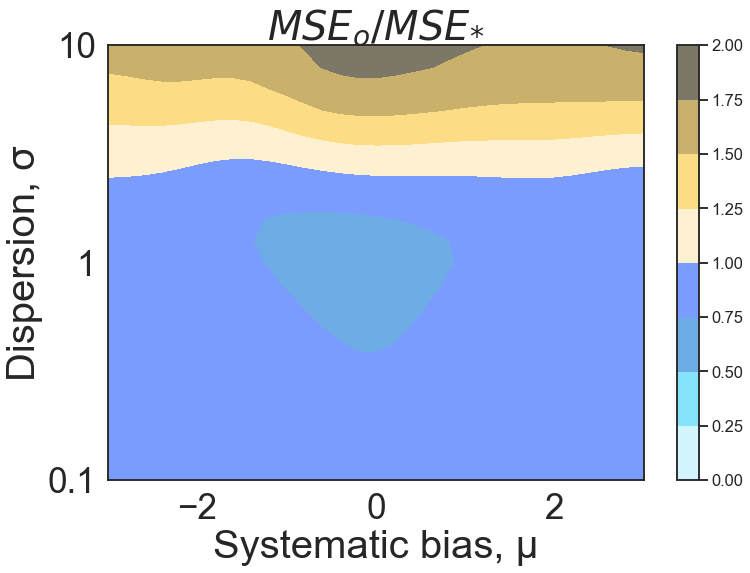

In [15]:
# Plot
sigma = 3
data = gaussian_filter(MSE_cycle.T/MSE_center.T, sigma)
μμ, σσ = np.meshgrid(μ, σ)

plot_loss(μμ, σσ ,data,save=True,title=r'$MSE_{o}/MSE_{*}$')

### Mean Absolute Error

In [16]:

MAE_center = np.zeros([len(μ),len(σ)])
MAE_cycle = np.zeros([len(μ),len(σ)])

w_center_ = w_center(n)
w_cycle_ = w_cycle(n)

for idx_n,μn in enumerate(μ):
    for idx_α,_α in enumerate(σ):
        for i in range(n_samples):
            s = signal_lognormal(n,m=μn,a=_α)

            center_MAE =  np.abs((w_center_@s) - θ)
            cycle_MAE = np.abs((w_cycle_@s) - θ)
            
            MAE_center[idx_n,idx_α] += center_MAE/n_samples
            MAE_cycle[idx_n,idx_α] += cycle_MAE/n_samples


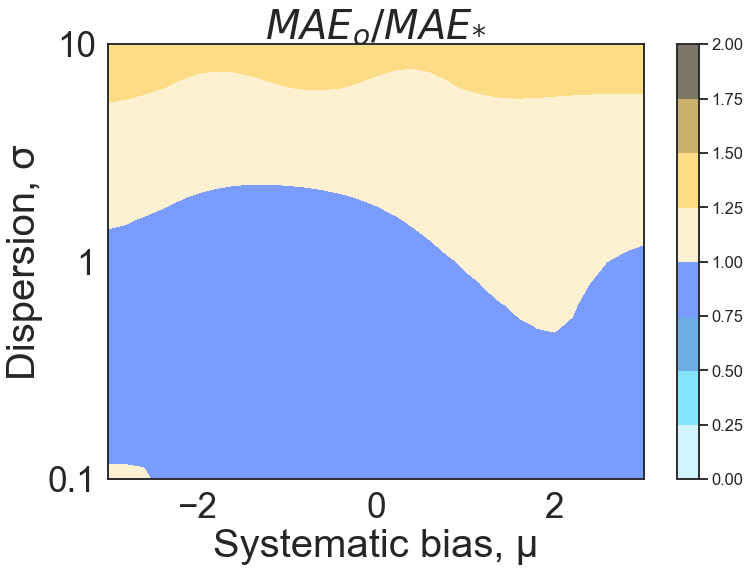

In [17]:
# Plot
sigma = 3
data = gaussian_filter(MAE_cycle.T/MAE_center.T, sigma)
μμ, σσ = np.meshgrid(μ, σ)

plot_loss(μμ, σσ ,data,save=True,title=r"$MAE_{o}/MAE_{*}$")


### Mean Square Root Error

In [18]:
MSRE_center = np.zeros([len(μ),len(σ)])
MSRE_cycle = np.zeros([len(μ),len(σ)])

w_center_ = w_center(n)
w_cycle_ = w_cycle(n)

for idx_n,μn in enumerate(μ):
    for idx_α,_α in enumerate(σ):
        for i in range(n_samples):
            s = signal_lognormal(n,m=μn,a=_α)

            center_MSRE =  np.sqrt(np.abs((w_center_@s) - θ))
            cycle_MSRE = np.sqrt(np.abs((w_cycle_@s) - θ))
            
            MSRE_center[idx_n,idx_α] += center_MSRE/n_samples
            MSRE_cycle[idx_n,idx_α] += cycle_MSRE/n_samples

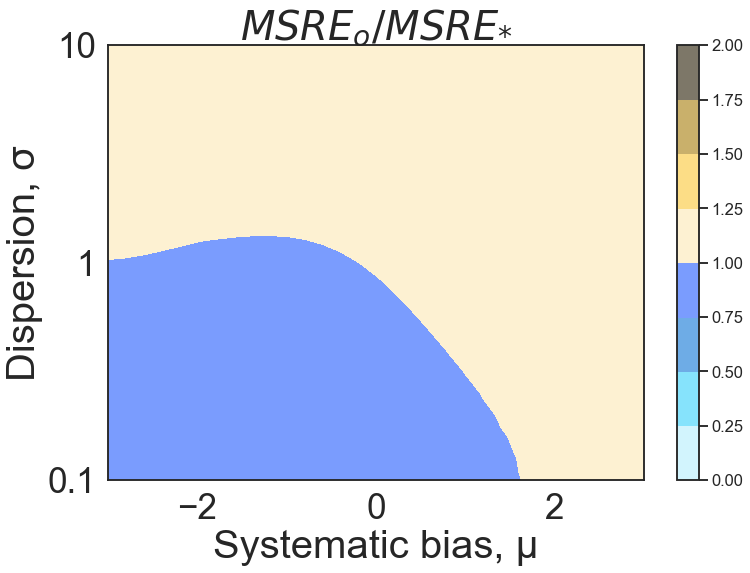

In [19]:
# Plot
sigma = 3
data = gaussian_filter(MSRE_cycle.T/MSRE_center.T, sigma)
μμ, σσ = np.meshgrid(μ, σ)

plot_loss(μμ, σσ ,data,save=True,title=r"$MSRE_{o}/MSRE_{*}$")